
# Fase 3: Análisis Exploratorio de Datos (EDA)
**Proyecto:** Pronóstico Mis Buñuelos  
**Objetivo:** Comprender la dinámica de la demanda, validar hipótesis de negocio y decisiones de modelado.

---

## 🚫 Reglas de Juego (Anti-Data Leakage)
Siguiendo la metodología estricta del proyecto, este análisis se rige por el principio **"Only Eyes on the Past"**:
1.  **Partición Estricta:** El dataset se dividirá en Entrenamiento, Validación y Pruebas.
2.  **Ceguera al Futuro:** Todo análisis de correlación, estacionalidad, tendencias y distribución se realizará **EXCLUSIVAMENTE** sobre el conjunto de **ENTRENAMIENTO**.
3.  **Prohibición de Espionaje:** Los conjuntos de Validación y Pruebas solo se visualizarán para contexto temporal, pero no influirán en la ingeniería de características.

## 🎯 Objetivos Específicos
1.  Validar la **estacionalidad** (Picos en Dic/Ene y Jun/Jul).
2.  Confirmar el impacto de las **promociones** (Abr-May, Sep-Oct).
3.  Evaluar la correlación de variables **macroeconómicas** y de **marketing**.
4.  Identificar y caracterizar el periodo de **Pandemia** ("Cisne Negro").


In [1]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings

# Configuración Global
warnings.filterwarnings('ignore')

# Lógica robusta para detectar la raíz del proyecto
# Si estamos en 'notebooks/', retrocedemos un nivel.
_cwd = Path(os.getcwd())
BASE_DIR = _cwd.parent if _cwd.name == "notebooks" else _cwd

# Cargar Configuración
config_path = BASE_DIR / "config.yaml"
with open(config_path, "r", encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Configuración Visual (Rich Aesthetics) & Output Paths
viz_config = config['visualization']
plt.style.use(viz_config['style'])
palette = viz_config['palette']
sns.set_palette(palette)

# Colores definidos
COLOR_TRAIN = viz_config['colors']['train']
COLOR_VAL = viz_config['colors']['val']
COLOR_TEST = viz_config['colors']['test']
COLOR_PANDEMIC = viz_config['colors']['pandemic_highlight']

FIG_SIZE_L = tuple(viz_config['figsize_large'])
FIG_SIZE_S = tuple(viz_config['figsize_small'])

# Rutas de Salida (Lab - Experiments)
EXPERIMENT_DIR = BASE_DIR / config['paths']['lab']['base'] / "phase_03_eda"
FIGURES_DIR = EXPERIMENT_DIR / "figures"
ARTIFACTS_DIR = EXPERIMENT_DIR / "artifacts"

# Crear directorios si no existen
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Entorno configurado. Salidas en: {EXPERIMENT_DIR}")

# Estructura para recolectar hallazgos del reporte JSON
eda_report = {
    "phase": "Phase 3 - Exploratory Data Analysis",
    "timestamp": datetime.now().isoformat(),
    "description": "Exploratory analysis of sales, promotions, and macro variables with stationarity tests and outlier detection.",
    "methodology": "Anti-Data Leakage (Only Eyes on Past)",
    "temporal_partition": {},
    "data_stats": {
        "train": {},
        "val": {},
        "test": {}
    },
    "business_insights": {
        "seasonality": {},
        "promotions": {},
        "macro_correlations": {},
        "marketing_lags": {}
    },
    "visualizations": [],
    "outliers_detected": {},
    "stationarity_test": {}
}


Entorno configurado. Salidas en: c:\Users\USUARIO\Documents\Forecaster\Forecaster_MisBunuelos\experiments\phase_03_eda


In [2]:

# Rutas
DATA_PATH = BASE_DIR / config['paths']['data']['cleansed'] / "master_monthly.parquet"

# Cargar Datos
df = pd.read_parquet(DATA_PATH)
df = df.sort_index()

# Validar Integridad Básica
print(f"Dataset Maestro Cargado: {df.shape}")
print(f"Rango de Fechas: {df.index.min().date()} a {df.index.max().date()}")

# Definir Cortes Temporales (Leídos de Config)
val_months = config['validation']['val_size_months']
test_months = config['validation']['test_size_months']

# Índices de Corte
end_train = df.index[- (val_months + test_months) - 1]
start_test = df.index[-test_months]
start_val = df.index[- (val_months + test_months)]

# Partición
df_train = df.loc[:end_train].copy()
df_val = df.loc[start_val : start_test - pd.Timedelta(days=1)].copy() # Justo antes de test
df_test = df.loc[start_test:].copy()

# Guardar Metadata del Split en Reporte
eda_report["temporal_partition"] = {
    "train_range": [str(df_train.index.min().date()), str(df_train.index.max().date())],
    "val_range": [str(df_val.index.min().date()), str(df_val.index.max().date())],
    "test_range": [str(df_test.index.min().date()), str(df_test.index.max().date())],
    "train_size": len(df_train),
    "val_size": len(df_val),
    "test_size": len(df_test)
}

print("-" * 30)
print(f"TRAIN: {df_train.index.min().date()} -> {df_train.index.max().date()} (n={len(df_train)})")
print(f"VAL:   {df_val.index.min().date()} -> {df_val.index.max().date()} (n={len(df_val)})")
print(f"TEST:  {df_test.index.min().date()} -> {df_test.index.max().date()} (n={len(df_test)})")


Dataset Maestro Cargado: (97, 18)
Rango de Fechas: 2018-01-01 a 2026-01-01
------------------------------
TRAIN: 2018-01-01 -> 2024-01-01 (n=73)
VAL:   2024-02-01 -> 2025-01-01 (n=12)
TEST:  2025-02-01 -> 2026-01-01 (n=12)


In [3]:

def get_detailed_stats(df):
    stats = {}
    
    # Identificar tipos de columnas
    all_cols = df.columns.tolist()
    
    for col in all_cols:
        col_data = df[col].dropna()
        if col_data.empty: continue
        
        # 1. Estadísticos principales (numéricos)
        desc = col_data.describe(percentiles=[.25, .5, .75, .90, .95]).to_dict()
        desc['range'] = float(col_data.max() - col_data.min())
        desc['median'] = float(col_data.median())
        
        col_stats = {
            "descriptive": {k: (float(v) if isinstance(v, (np.number, float, int)) else v) for k, v in desc.items()}
        }
        
        # 2. Análisis de Variables Booleanas (0/1 o True/False)
        unique_vals = col_data.unique()
        is_bool_numeric = set(unique_vals).issubset({0, 1, 0.0, 1.0})
        is_bool_type = col_data.dtype == bool or np.issubdtype(col_data.dtype, np.bool_)
        
        if is_bool_numeric or is_bool_type:
            counts = col_data.value_counts(normalize=False).sort_index().to_dict()
            proportions = col_data.value_counts(normalize=True).sort_index().to_dict()
            col_stats["boolean_analysis"] = {
                "counts": {str(int(k)): int(v) for k, v in counts.items()},
                "proportions": {str(int(k)): round(float(v), 4) for k, v in proportions.items()}
            }
            
        # 3. Detección de Atípicos (IQR)
        if np.issubdtype(col_data.dtype, np.number) and not set(unique_vals).issubset({0, 1, 0.0, 1.0}):
            q1 = col_data.quantile(0.25)
            q3 = col_data.quantile(0.75)
            iqr = q3 - q1
            lower_limit = q1 - 1.5 * iqr
            upper_limit = q3 + 1.5 * iqr
            
            outliers = col_data[(col_data < lower_limit) | (col_data > upper_limit)]
            
            col_stats["outliers_iqr"] = {
                "lower_limit": round(float(lower_limit), 4),
                "upper_limit": round(float(upper_limit), 4),
                "count": int(len(outliers)),
                "percentage": round(float(len(outliers) / len(col_data)) * 100, 2) if len(col_data) > 0 else 0
            }
            
        stats[col] = col_stats
    return stats

# Ejecutar para cada set
eda_report["data_stats"] = {
    "train": get_detailed_stats(df_train),
    "val": get_detailed_stats(df_val),
    "test": get_detailed_stats(df_test)
}

# Mostrar resumen de atípicos para el reporte rápido
outlier_summary = {}
for col, info in eda_report["data_stats"]["train"].items():
    if "outliers_iqr" in info:
        outlier_summary[col] = info["outliers_iqr"]["count"]

eda_report["outliers_detected"] = outlier_summary

# 4. Test de Dickey-Fuller Aumentado (ADF) - Estacionariedad
target_col = config['project']['target_column']
adf_res = adfuller(df_train[target_col].dropna())

eda_report["stationarity_test"] = {
    "variable": target_col,
    "adf_statistic": round(float(adf_res[0]), 4),
    "p_value": round(float(adf_res[1]), 4),
    "is_stationary": bool(adf_res[1] < 0.05),
    "critical_values": {k: round(float(v), 4) for k, v in adf_res[4].items()}
}

print("✅ Análisis estadístico y detección de atípicos completado.")
print(f"Atípicos detectados en TRAIN: {outlier_summary}")
print(f"Dickey-Fuller Test (P-Value): {eda_report['stationarity_test']['p_value']}")


✅ Análisis estadístico y detección de atípicos completado.
Atípicos detectados en TRAIN: {'total_unidades_entregadas': 5, 'unidades_precio_normal': 0, 'unidades_promo_pagadas': 8, 'unidades_promo_bonificadas': 8, 'precio_unitario_full': 0, 'costo_unitario': 0, 'ingresos_totales': 2, 'costo_total': 2, 'utilidad': 2, 'inversion_facebook': 12, 'inversion_instagram': 12, 'inversion_total': 12, 'dias_en_promo': 8, 'ipc_mensual': 0, 'trm_promedio': 1, 'tasa_desempleo': 17, 'costo_insumos_index': 0, 'confianza_consumidor': 12}
Dickey-Fuller Test (P-Value): 0.2587


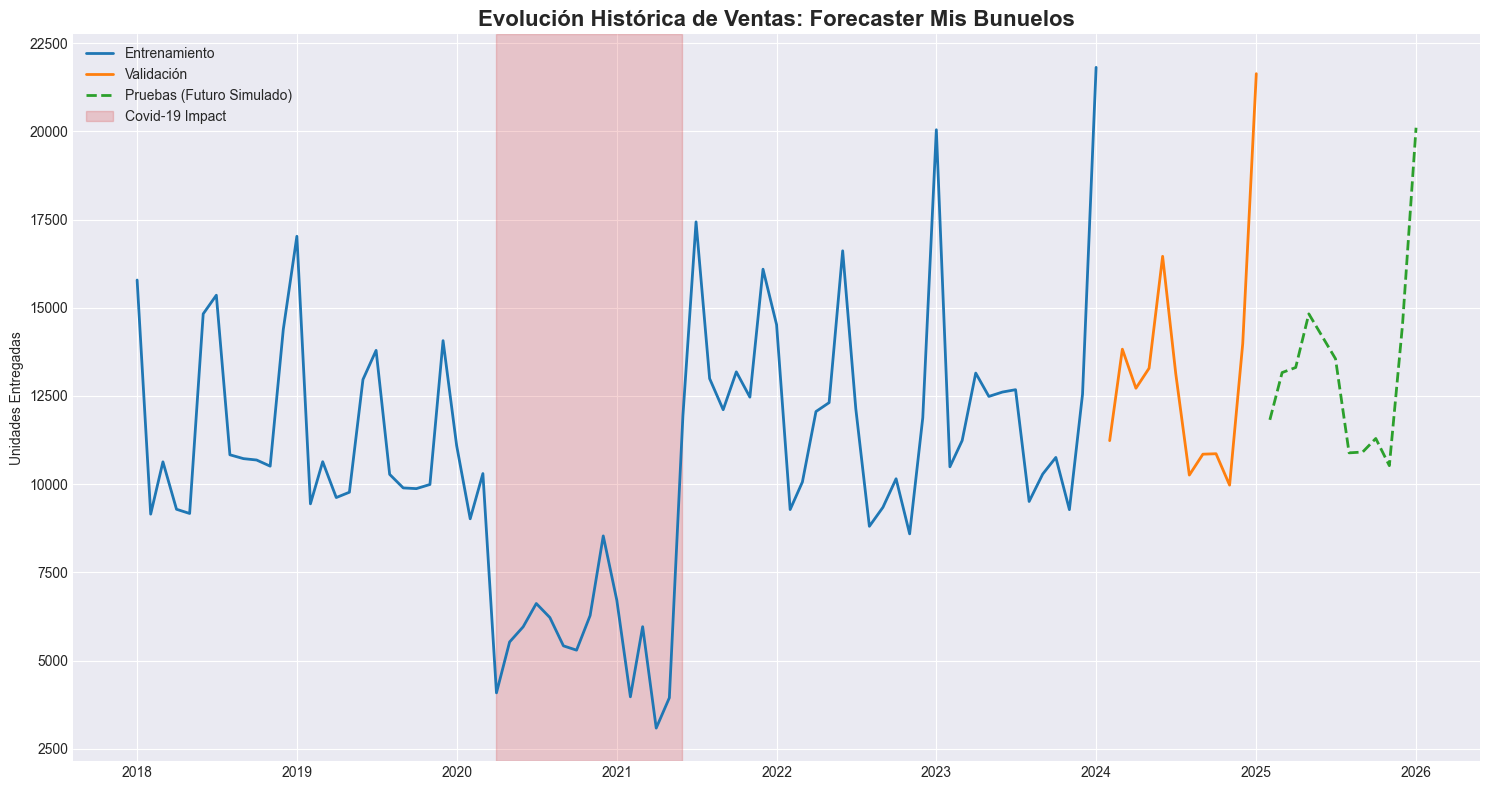

Figura guardada: c:\Users\USUARIO\Documents\Forecaster\Forecaster_MisBunuelos\experiments\phase_03_eda\figures\01_serie_temporal_completa.png


In [4]:

# Hipótesis: Cisne Negro (Pandemia)
pandemic_cfg = config['business_events']['pandemic']
pandemic_start = pd.to_datetime(pandemic_cfg['start_date'])
pandemic_end = pd.to_datetime(pandemic_cfg['end_date'])

plt.figure(figsize=FIG_SIZE_L)

# Plotear Sets
plt.plot(df_train.index, df_train['total_unidades_entregadas'], label='Entrenamiento', color=COLOR_TRAIN, linewidth=2)
plt.plot(df_val.index, df_val['total_unidades_entregadas'], label='Validación', color=COLOR_VAL, linewidth=2)
plt.plot(df_test.index, df_test['total_unidades_entregadas'], label='Pruebas (Futuro Simulado)', color=COLOR_TEST, linewidth=2, linestyle='--')

# Sombrear Pandemia
plt.axvspan(pandemic_start, pandemic_end, color=COLOR_PANDEMIC, alpha=0.2, label=pandemic_cfg['label'])

# Decoración
plt.title(f"Evolución Histórica de Ventas: {config['project']['name']}", fontsize=16, fontweight='bold')
plt.ylabel("Unidades Entregadas")
plt.legend()
plt.tight_layout()

# Guardar Figura
fig_name = "01_serie_temporal_completa.png"
plt.savefig(FIGURES_DIR / fig_name)
eda_report["visualizations"].append(fig_name)
plt.show()

print(f"Figura guardada: {FIGURES_DIR / fig_name}")



## 5. Análisis de Estacionalidad (Solo Entrenamiento)
Validación de la hipótesis del cliente: *"Picos en Diciembre/Enero y Junio/Julio".*


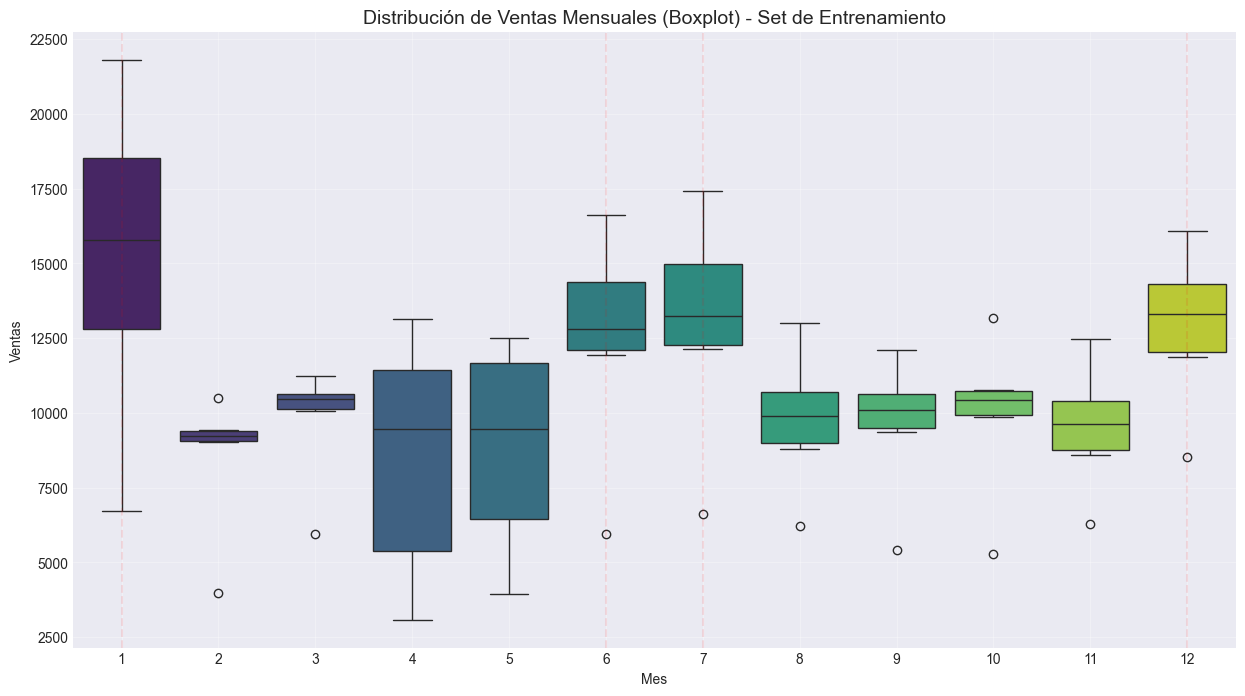

Índices Estacionales (Promedio Train):
month
1     1.43
2     0.80
3     0.92
4     0.80
5     0.83
6     1.17
7     1.22
8     0.91
9     0.90
10    0.93
11    0.89
12    1.21
Name: total_unidades_entregadas, dtype: float64


In [5]:

# Preparar datos: Agregar columnas de mes y año
df_train_viz = df_train.copy()
df_train_viz['month'] = df_train_viz.index.month
df_train_viz['year'] = df_train_viz.index.year

plt.figure(figsize=FIG_SIZE_L)
sns.boxplot(data=df_train_viz, x='month', y='total_unidades_entregadas', palette=palette)

# Highlight meses clave (Hipótesis)
meses_pico = [1, 6, 7, 12]
for month in meses_pico:
    plt.axvline(x=month-1, color='red', alpha=0.1, linestyle='--') # month-1 por índice 0

plt.title("Distribución de Ventas Mensuales (Boxplot) - Set de Entrenamiento", fontsize=14)
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.grid(True, alpha=0.3)

# Guardar Figura
fig_name = "02_estacionalidad_boxplot.png"
plt.savefig(FIGURES_DIR / fig_name)
eda_report["visualizations"].append(fig_name)
plt.show()

# Calcular Estacionalidad Promedio y guardar en reporte
seasonal_idx = df_train_viz.groupby('month')['total_unidades_entregadas'].mean()
seasonal_idx_norm = seasonal_idx / seasonal_idx.mean()

eda_report["business_insights"]["seasonality"] = {
    "indices": seasonal_idx_norm.round(2).to_dict(),
    "peak_months_validated": [m for m in meses_pico if seasonal_idx_norm[m] > 1.1] # Umbral arbitrario de 1.1 (10% sobre media)
}

print("Índices Estacionales (Promedio Train):")
print(seasonal_idx_norm.round(2))



## 6. Validación de Promociones
Hipótesis: *"Las promociones en Abr-May y Sep-Oct levantan la venta."*


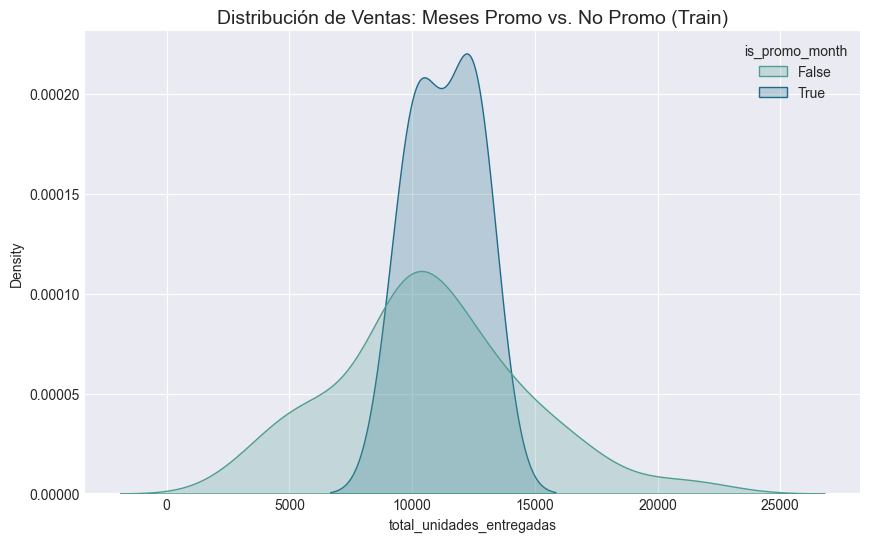

                count     mean     std     min      25%      50%      75%  \
is_promo_month                                                              
False            65.0  10693.5  3831.6  3087.0   9019.0  10493.0  12678.0   
True              8.0  11318.5  1356.6  9345.0  10252.8  11408.5  12355.0   

                    max  
is_promo_month           
False           21813.0  
True            13149.0  


In [6]:

# Definir Flag de Promo si no existe (usando dias_en_promo > 0)
# Nota: 'dias_en_promo' viene de la agregación de 'es_promo'
df_train_viz['is_promo_month'] = df_train_viz['dias_en_promo'] > 5 # Al menos 5 días de promo para considerar el mes

plt.figure(figsize=FIG_SIZE_S)
sns.kdeplot(data=df_train_viz, x='total_unidades_entregadas', hue='is_promo_month', fill=True, common_norm=False, palette='crest')
plt.title("Distribución de Ventas: Meses Promo vs. No Promo (Train)", fontsize=14)

# Guardar Figura
fig_name = "03_impacto_promo_distribucion.png"
plt.savefig(FIGURES_DIR / fig_name)
eda_report["visualizations"].append(fig_name)
plt.show()

# Estadística descriptiva y Test de Hipótesis (Simplificado)
stats_promo = df_train_viz.groupby('is_promo_month')['total_unidades_entregadas'].describe().round(1)
eda_report["business_insights"]["promotions"] = {
    "stats": stats_promo.to_dict(),
    "uplift_observed": bool(stats_promo.loc[True, 'mean'] > stats_promo.loc[False, 'mean']) if True in stats_promo.index else False
}
print(stats_promo)



## 7. Análisis Multivariado: Macroeconomía
Hipótesis: *"Inflación y Desempleo afectan la venta."* Analizamos correlaciones.


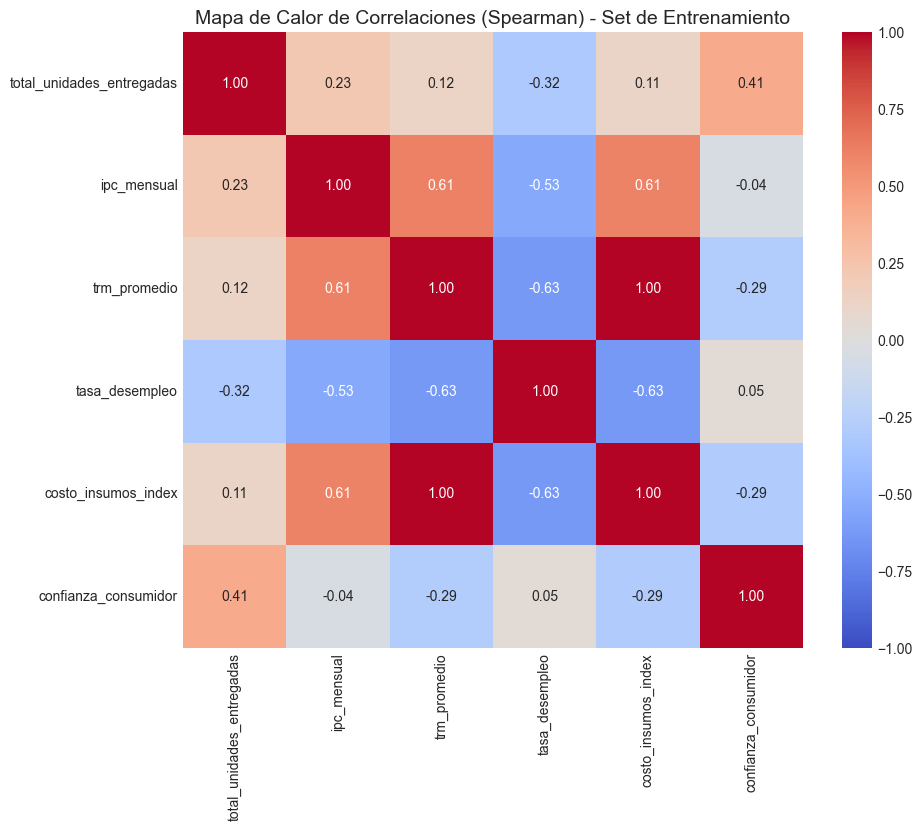

In [7]:

# Seleccionar variables macro y target
target = 'total_unidades_entregadas'
macro_cols = ['ipc_mensual', 'trm_promedio', 'tasa_desempleo', 'costo_insumos_index', 'confianza_consumidor']
cols_to_corr = [target] + [c for c in macro_cols if c in df_train.columns]

# Matriz de correlación (Solo Train)
corr_matrix = df_train[cols_to_corr].corr(method='spearman') # Spearman para capturar no lineales

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Mapa de Calor de Correlaciones (Spearman) - Set de Entrenamiento", fontsize=14)

# Guardar Figura
fig_name = "04_correlacion_heatmap.png"
plt.savefig(FIGURES_DIR / fig_name)
eda_report["visualizations"].append(fig_name)
plt.show()

# Guardar top correlaciones en reporte
top_corr = corr_matrix[target].drop(target).sort_values(ascending=False)
eda_report["business_insights"]["macro_correlations"] = top_corr.round(3).to_dict()



## 8. Impacto de Marketing (Lag Analysis)
Hipótesis: *"La inversión en RRSS tiene efecto inmediato o rezagado."*


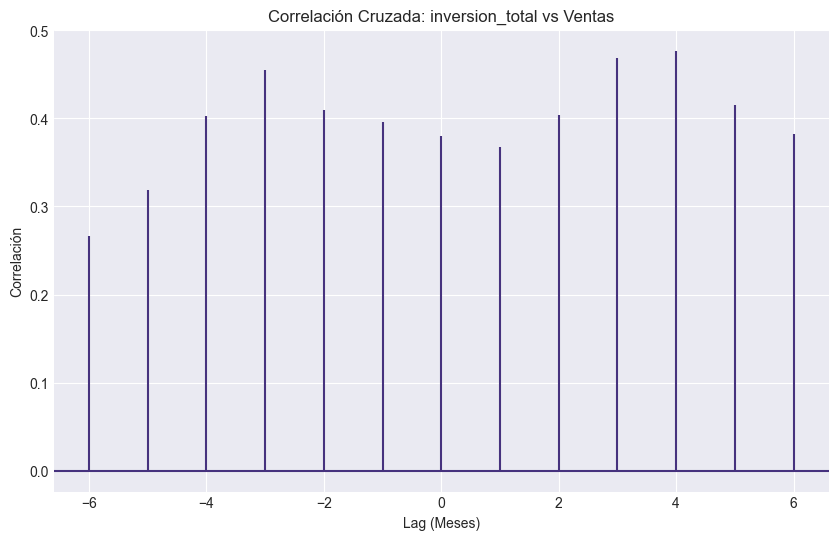

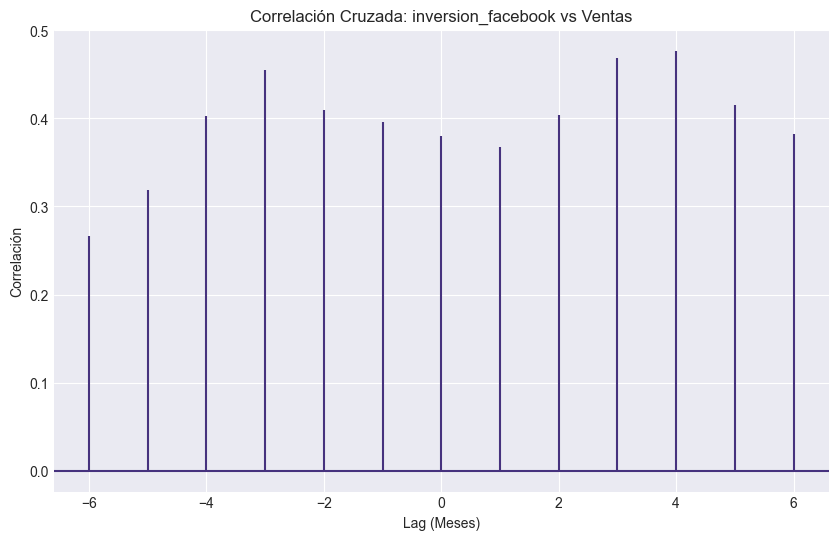

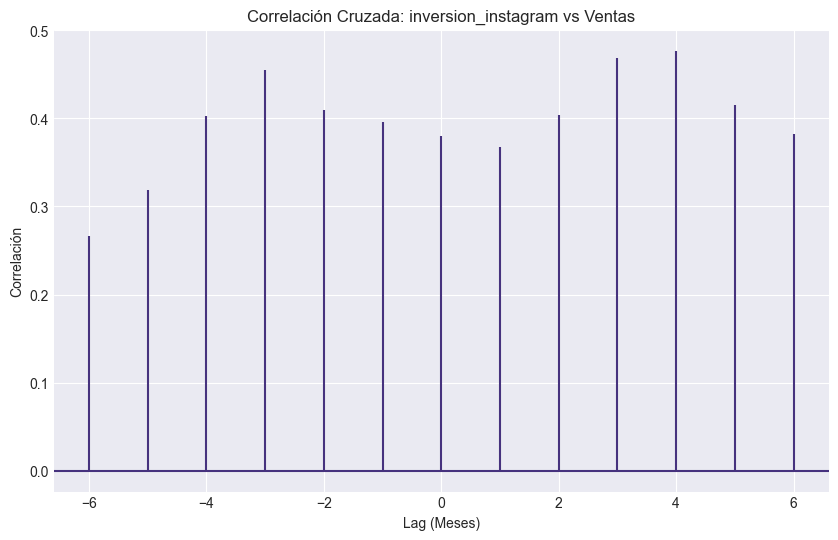

In [8]:

# Variables de Marketing
mkt_cols = ['inversion_total', 'inversion_facebook', 'inversion_instagram']
available_mkt = [c for c in mkt_cols if c in df_train.columns]

if available_mkt:
    for i, col in enumerate(available_mkt):
        # Cross Correlation
        plt.figure(figsize=FIG_SIZE_S)
        plt.xcorr(df_train[col].astype(float), df_train[target].astype(float), maxlags=6, usevlines=True, normed=True)
        plt.title(f"Correlación Cruzada: {col} vs Ventas", fontsize=12)
        plt.xlabel("Lag (Meses)")
        plt.ylabel("Correlación")
        plt.grid(True)
        
        # Guardar Figura
        fig_name = f"05_marketing_lag_{col}.png"
        plt.savefig(FIGURES_DIR / fig_name)
        eda_report["visualizations"].append(fig_name)
        plt.show()
else:
    print("No se encontraron columnas de inversión de marketing agregadas.")



## 9. Dinámica Temporal (ACF/PACF)
Crucial para definir los *Lags* del modelo.


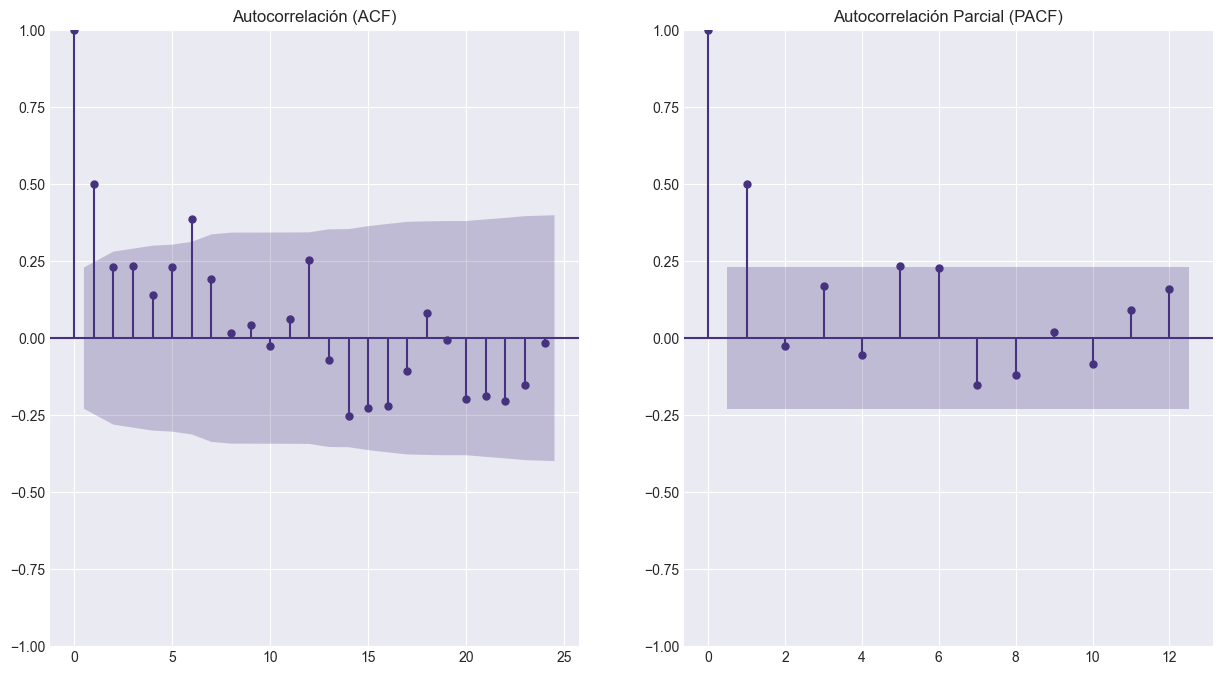

In [9]:

plt.figure(figsize=FIG_SIZE_L)
plt.subplot(121)
plot_acf(df_train[target], lags=24, ax=plt.gca())
plt.title("Autocorrelación (ACF)")

plt.subplot(122)
plot_pacf(df_train[target], lags=12, ax=plt.gca())
plt.title("Autocorrelación Parcial (PACF)")

# Guardar Figura
fig_name = "06_autocorrelacion_acf_pacf.png"
plt.savefig(FIGURES_DIR / fig_name)
eda_report["visualizations"].append(fig_name)
plt.show()



## 10. Generación de Reporte de Fase
Compilación automática de hallazgos y metadatos en formato JSON.


In [10]:

import json
# Generar timestamp para el nombre del archivo
timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
report_filename = f"phase_03_eda_{timestamp_str}.json"
report_path = ARTIFACTS_DIR / report_filename

# Guardar JSON
with open(report_path, "w", encoding='utf-8') as f:
    json.dump(eda_report, f, indent=4)
    
print(f"✅ Reporte detallado generado en: {report_path}")
print(json.dumps(eda_report, indent=2))


✅ Reporte detallado generado en: c:\Users\USUARIO\Documents\Forecaster\Forecaster_MisBunuelos\experiments\phase_03_eda\artifacts\phase_03_eda_20260215_175342.json
{
  "phase": "Phase 3 - Exploratory Data Analysis",
  "timestamp": "2026-02-15T17:53:40.498230",
  "description": "Exploratory analysis of sales, promotions, and macro variables with stationarity tests and outlier detection.",
  "methodology": "Anti-Data Leakage (Only Eyes on Past)",
  "temporal_partition": {
    "train_range": [
      "2018-01-01",
      "2024-01-01"
    ],
    "val_range": [
      "2024-02-01",
      "2025-01-01"
    ],
    "test_range": [
      "2025-02-01",
      "2026-01-01"
    ],
    "train_size": 73,
    "val_size": 12,
    "test_size": 12
  },
  "data_stats": {
    "train": {
      "total_unidades_entregadas": {
        "descriptive": {
          "count": 73.0,
          "mean": 10761.972602739726,
          "std": 3642.4989284395688,
          "min": 3087.0,
          "25%": 9170.0,
          "50%":